<a href="https://colab.research.google.com/github/abysssdweller/QML/blob/main/QRC/QRC_RepeatedMeasurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Reservoir Computing with Repeated Measurements (Yasuda et al., arXiv:2310.06706v1) — PennyLane/Colab Notebook

This notebook implements the **paper’s QRC architecture** (6 parallel 4-qubit units) and evaluates on **NARMA2 / NARMA5 / NARMA10**.

**Key implementation choices (match paper):**
- 6 units → total **24 qubits** = 12 system + 12 ancilla
- Per timestep: encode scalar input \(u_t\) via \(s = a u_t\) with **RX/RZ** + CNOT pattern
- Couple system→ancilla (CNOTs), then **mid-circuit measure + reset** ancillas each timestep
- Train only linear readout by least squares

In [1]:
# =========================
# Install dependencies (Colab)
# =========================
!pip -q install "pennylane>=0.40" numpy scipy tqdm
!pip -q install dtaidistance || true

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 12.2 MB/s eta 0:00:00


In [2]:
# =========================
# Imports + utilities
# =========================
import numpy as np
import pennylane as qml
from dataclasses import dataclass
from typing import Optional, List, Tuple, Dict
from tqdm.auto import tqdm

np.set_printoptions(precision=4, suppress=True)

def set_global_seed(seed: int):
    np.random.seed(seed)

In [3]:
@dataclass
class QRCConfig:
    n_units: int = 6
    scale_a: float = 2.0
    shots: int = 8192
    backend: str = "default.qubit"
    seed: int = 0

def build_wires(n_units: int):
    sys, anc = [], []
    for i in range(n_units):
        sys.append((4*i, 4*i+1))
        anc.append((4*i+2, 4*i+3))
    return sys, anc

def U_sys_paper(s: float, j: int, k: int):
    qml.CNOT(wires=[j, k])
    qml.RX(s, wires=j)
    qml.RZ(s, wires=k)
    qml.CNOT(wires=[j, k])
    qml.RX(s, wires=j)

def Ubar_paper(s: float, j: int, k: int, l: int, m: int):
    U_sys_paper(s, j, k)
    qml.CNOT(wires=[j, l])
    qml.CNOT(wires=[k, m])

## 3) Repeated-measurement rollout (dynamic circuit)

We must ensure **all mid-circuit measurements happen before any terminal measurements**.
So we store `qml.measure(..., reset=True)` into a list, then return `qml.sample(...)` at the end.

In [4]:
def run_repeated_measurement(u: np.ndarray, cfg: QRCConfig):
    set_global_seed(cfg.seed)
    u = np.asarray(u, float)
    L = len(u)

    sys_pairs, anc_pairs = build_wires(cfg.n_units)
    n_qubits = 4 * cfg.n_units
    n_anc = 2 * cfg.n_units

    dev = qml.device(cfg.backend, wires=n_qubits)

    @qml.set_shots(cfg.shots)
    @qml.qnode(dev, mcm_method="one-shot")
    def circuit(u_seq):
        mids = []
        for t in range(L):
            s = cfg.scale_a * u_seq[t]

            for (sys_w, anc_w) in zip(sys_pairs, anc_pairs):
                j,k = sys_w
                l,m = anc_w
                Ubar_paper(s, j,k,l,m)

            for (l,m) in anc_pairs:
                mids.append(qml.measure(l, reset=True))
                mids.append(qml.measure(m, reset=True))

        return tuple(qml.sample(m) for m in mids)

    raw = circuit(u)  # length L*n_anc
    bits_flat = np.stack([np.asarray(r, dtype=np.int8) for r in raw], axis=1)  # (shots, L*n_anc)
    bits = bits_flat.reshape(cfg.shots, L, n_anc)                               # (shots, L, n_anc)
    zexp = np.mean(1.0 - 2.0 * bits, axis=0)                                    # (L, n_anc)
    return zexp

## 4) NARMA input and target (paper)

In [5]:
def paper_input_u(L=100, T=100, a=2.11, b=3.73, c=4.11):
    t = np.arange(L, dtype=float)
    return 0.1 * (np.sin(2*np.pi*a*t/T) * np.sin(2*np.pi*b*t/T) * np.sin(2*np.pi*c*t/T) + 1.0)

def narma2(u: np.ndarray):
    L = len(u)
    y = np.zeros(L+1, dtype=float)
    for t in range(L):
        y[t+1] = 0.4*y[t] + 0.4*y[t]*y[t-1] + 0.6*(u[t]**3) + 0.1
    return y[1:]

def narma_n(u: np.ndarray, n: int, alpha=0.3, beta=0.05, gamma=1.5, delta=0.1):
    L = len(u)
    y = np.zeros(L+1, dtype=float)
    for t in range(L):
        s = 0.0
        for i in range(n):
            idx = t - i
            if idx >= 0:
                s += y[idx]
        u_del = u[t-n+1] if (t-n+1) >= 0 else 0.0
        y[t+1] = alpha*y[t] + beta*y[t]*s + gamma*u_del*u[t] + delta
    return y[1:]

def make_task(task: str, L=100):
    u = paper_input_u(L=L)
    if task == "narma2":
        y = narma2(u)
    elif task == "narma5":
        y = narma_n(u, n=5)
    elif task == "narma10":
        y = narma_n(u, n=10)
    else:
        raise ValueError("task must be narma2/narma5/narma10")
    return u, y

## 5) Metrics: MSE + DTW

In [6]:
def mse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return np.mean((y_true - y_pred)**2)

try:
    from dtaidistance import dtw as _dtw_fast
    def dtw_distance(a, b):
        return float(_dtw_fast.distance(np.asarray(a, float), np.asarray(b, float)))
    print("DTW: using dtaidistance")
except Exception:
    def dtw_distance(a, b):
        a = np.asarray(a, float); b = np.asarray(b, float)
        M, N = len(a), len(b)
        D = np.full((M+1, N+1), np.inf, dtype=float)
        D[0,0] = 0.0
        for i in range(1, M+1):
            for j in range(1, N+1):
                cost = abs(a[i-1] - b[j-1])
                D[i,j] = cost + min(D[i-1,j], D[i,j-1], D[i-1,j-1])
        return float(D[M,N])
    print("DTW: using fallback DP (slower)")

DTW: using dtaidistance


## 6) Linear readout

In [7]:
def fit_linear_readout(H: np.ndarray, y: np.ndarray, t_train=(10,80)):
    t0, t1 = t_train
    X = H[t0:t1]
    ytr = y[t0:t1]
    Xb = np.hstack([X, np.ones((X.shape[0], 1))])
    w, *_ = np.linalg.lstsq(Xb, ytr, rcond=None)
    return w

def predict_linear_readout(H: np.ndarray, w: np.ndarray):
    Xb = np.hstack([H, np.ones((H.shape[0], 1))])
    return Xb @ w

## 7) Run NARMA2/5/10 (repeated measurement)

Protocol:
- L=100
- washout 0–10
- train 10–80
- test 80–100

In [10]:
def run_narma_experiment_repeated(task: str, cfg: QRCConfig, trials: int = 3,
                                 L: int = 100,
                                 washout: int = 10,
                                 train_end: int = 80,
                                 test_end: int = 100) -> Dict:
    u, y = make_task(task, L=L)
    mses, dtws = [], []

    for tr in tqdm(range(trials), desc=f"{task} trials"):
        cfg_trial = QRCConfig(**cfg.__dict__)
        cfg_trial.seed = cfg.seed + tr

        H = run_repeated_measurement(u, cfg_trial)
        w = fit_linear_readout(H, y, t_train=(washout, train_end))
        yhat = predict_linear_readout(H, w)

        y_true = y[train_end:test_end]
        y_pred = yhat[train_end:test_end]
        mses.append(mse(y_true, y_pred))
        dtws.append(dtw_distance(y_true, y_pred))

    return {
        "task": task,
        "mse_mean": float(np.mean(mses)),
        "mse_std": float(np.std(mses)),
        "dtw_mean": float(np.mean(dtws)),
        "dtw_std": float(np.std(dtws)),
        "mse_trials": mses,
        "dtw_trials": dtws,
    }

# Quick run (increase shots/trials later)
cfg = QRCConfig(n_units=1, scale_a=2.0, shots=512, backend="default.qubit", seed=0)

results = {}
for task in ["narma2", "narma5", "narma10"]:
    res = run_narma_experiment_repeated(task, cfg=cfg, trials=3)
    results[task] = res
    print(f"{task}: MSE={res['mse_mean']:.6g}±{res['mse_std']:.2g} | DTW={res['dtw_mean']:.6g}±{res['dtw_std']:.2g}")

narma2 trials:   0%|          | 0/3 [00:00<?, ?it/s]

narma2: MSE=1.39857e-06±8.5e-08 | DTW=0.00397221±0.00091


narma5 trials:   0%|          | 0/3 [00:00<?, ?it/s]

narma5: MSE=0.000114643±5.2e-05 | DTW=0.0346881±0.011


narma10 trials:   0%|          | 0/3 [00:00<?, ?it/s]

narma10: MSE=0.00018298±7.4e-05 | DTW=0.0440731±0.0096


## 8) Plot one run

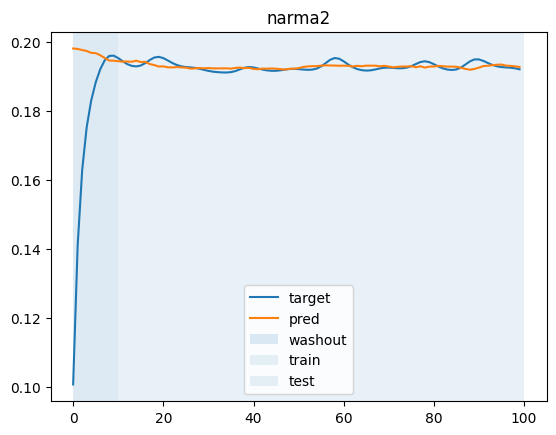

In [11]:
import matplotlib.pyplot as plt

def plot_one(task="narma2", cfg=cfg):
    u, y = make_task(task, L=100)
    H = run_repeated_measurement(u, cfg)
    w = fit_linear_readout(H, y, t_train=(10,80))
    yhat = predict_linear_readout(H, w)

    plt.figure()
    plt.plot(y, label="target")
    plt.plot(yhat, label="pred")
    plt.axvspan(0,10, alpha=0.15, label="washout")
    plt.axvspan(10,80, alpha=0.10, label="train")
    plt.axvspan(80,100, alpha=0.10, label="test")
    plt.title(task)
    plt.legend()
    plt.show()

plot_one("narma2", cfg)